In [522]:
import os
import os.path as osp
import cv2
import copy
import random
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
from collections import Counter

from torch.utils.data import Dataset,DataLoader
from torchvision import transforms as T
import torch
import torch.nn as nn

from models.Network import Face_Detection_Model
from dataloader.dataloader import Facedata_Loader

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
    
## Set seeds
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# seed = 7023001
seed = 1
seed_everything(seed)



Using device: cuda:1


In [523]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        
        var = 0.1
        
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        s_vs_p = 1

        amount = 0.004
        amout = 3
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
#         print(image.shape,num_salt)
#         print('??',np.random.randint(0, 366 - 1, int(num_salt)),image.shape)
        out[tuple(coords)] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[tuple(coords)] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

In [524]:
class FaceData(Dataset):
    def __init__(self,data_paths,transform_apply=True) :
        self.data_paths = data_paths
        self.transform_apply = transform_apply
        
        normalize = T.Normalize(mean=[0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
        self.transforms = T.Compose([
            T.ToTensor(),
            normalize
        ])
        
    def __getitem__(self, index):
        rgb_path = self.data_paths[index][0]
        cloud_path = self.data_paths[index][1]
        
        # crop setting
        crop_width = 90
        crop_height = 150
        mid_x, mid_y = 90, 90
        offset_x, offset_y = crop_width//2, crop_height//2
        
        # RGB open and crop 
        data = cv2.imread(rgb_path)
        data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
        data = cv2.resize(data, (180,180), interpolation=cv2.INTER_CUBIC)
#         data = data[mid_y-offset_y:mid_y+offset_y, mid_x-offset_x:mid_x+offset_x]     
        
        if (self.transform_apply) and (self.transforms is not None) :
            data = self.transforms(data)
            
        # Point Cloud(192, 256, 3) open and crop 
        cloud_data = np.load(cloud_path)
        cloud_data = cv2.resize(cloud_data, (180,180), interpolation=cv2.INTER_CUBIC)
        cloud_data += 5
#         cloud_data = cloud_data[mid_y-offset_y:mid_y+offset_y, mid_x-offset_x:mid_x+offset_x]
        
        ###### [!!!]  If A data is not scaled, it causes low performance.
        shift_value = 0
        xcoor = np.array(cloud_data[:, :, 0] + shift_value)
        ycoor = np.array(cloud_data[:, :, 1] + shift_value)
        zcoor = np.array(cloud_data[:, :, 2] + shift_value)
        depth = np.array(cloud_data[:, :, 3] + shift_value)
        
        xcoor = (xcoor-xcoor.mean())/xcoor.std()
        ycoor = (ycoor-ycoor.mean())/ycoor.std()
        zcoor = (zcoor-zcoor.mean())/zcoor.std()
        depth = (depth-depth.mean())/depth.std()     

        scaled_cloud = np.concatenate([xcoor[np.newaxis,:],ycoor[np.newaxis,:],zcoor[np.newaxis,:]])
        scaled_cloud_depth = np.concatenate([xcoor[np.newaxis,:],ycoor[np.newaxis,:],zcoor[np.newaxis,:],depth[np.newaxis,:]])
  
        # label - { 0 : real , 1 : mask }
        if 'bonafide' in rgb_path :
            label = 0
        elif 'attack_mask' in rgb_path :
            label = 1
        elif 'attack_replay' in rgb_path :
            label = 1
        elif 'attack_paper' in rgb_path :
            label = 1
        return data,scaled_cloud,scaled_cloud_depth,label
    
    def __len__(self):
        return len(self.data_paths)

In [525]:
data_path = "/mnt/nas3/yrkim/liveness_lidar_project/GC_project/LDFAS"
npy_path = '/mnt/nas3/yrkim/liveness_lidar_project/GC_project/LDFAS/NPY_Files'

experiment_type = "pm"

person_number = [i for i in range(16,17)]
traindata_portion = 0

train_img_paths, test_img_paths = [],[]
for i in person_number :
    img_path = osp.join(data_path,str(i),'bonafide')
    files = os.listdir(img_path)
    files = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='rgb')]
    random.shuffle(files)
    
    bonafide_files = [osp.join(data_path,str(i),'bonafide',j) for j in files]
    paper_files= [osp.join(data_path,str(i),'attack_paper',j) for j in files]
    replay_files= [osp.join(data_path,str(i),'attack_replay',j) for j in files]
    mask_files= [osp.join(data_path,str(i),'attack_mask',j) for j in files]

    bonafide_cloud_files = [osp.join(npy_path, 'real_cloud_data',j.split('/')[-3], 
                            (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in bonafide_files]
    paper_cloud_files = [osp.join(npy_path, 'paper_cloud_data',j.split('/')[-3], 
                            (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in paper_files]
    replay_cloud_files = [osp.join(npy_path, 'replay_cloud_data',j.split('/')[-3], 
                            (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in replay_files]
    mask_cloud_files = [osp.join(npy_path, 'mask_cloud_data',j.split('/')[-3], 
                            (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in mask_files]

    # bonafide
    train_img_paths += list(zip(bonafide_files,bonafide_cloud_files))[:int(len(bonafide_files)*traindata_portion)]
    test_img_paths += list(zip(bonafide_files,bonafide_cloud_files))[int(len(bonafide_files)*traindata_portion):]
    
    # PAs
    if "r" in experiment_type:
        train_img_paths += list(zip(replay_files,replay_cloud_files))[:int(len(replay_files)*traindata_portion)]
        test_img_paths += list(zip(replay_files,replay_cloud_files))[int(len(replay_files)*traindata_portion):]
    if "p" in experiment_type:
        train_img_paths += list(zip(paper_files,paper_cloud_files))[:int(len(paper_files)*traindata_portion)]
        test_img_paths += list(zip(paper_files,paper_cloud_files))[int(len(paper_files)*traindata_portion):]
    if "m" in experiment_type:
        train_img_paths += list(zip(mask_files,mask_cloud_files))[:int(len(mask_files)*traindata_portion)]
        test_img_paths += list(zip(mask_files,mask_cloud_files))[int(len(mask_files)*traindata_portion):]
     
test_img_paths = sorted(test_img_paths)
# test_img_paths

In [526]:
batch_size = 1
num_workers = 1

test_dataset = FaceData(test_img_paths,transform_apply=False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# RGB paper
# model_path = "/mnt/nas3/yrkim/liveness_lidar_project/GC_project/bc_output/checkpoint/0721_data15_82_rgb_p/epoch_18_model.pth"

# RGB mask
# model_path = "/mnt/nas3/yrkim/liveness_lidar_project/GC_project/bc_output/checkpoint/0721_data15_82_rgb_m/epoch_71_model.pth"

# RGB+PointCloud paper
# model_path = "/mnt/nas3/yrkim/liveness_lidar_project/GC_project/bc_output/checkpoint/0721_data15_82_rgbp_p/epoch_0_model.pth"

# RGB+PointCloud mask
# model_path = "/mnt/nas3/yrkim/liveness_lidar_project/GC_project/bc_output/checkpoint/0721_data15_82_rgbp_m/epoch_32_model.pth"

# RGB+PointCloud  rpm all 
model_path = "/mnt/nas3/yrkim/liveness_lidar_project/GC_project/bc_output/checkpoint/0721_data15_82_rgbp_prm/epoch_44_model.pth"



model = Face_Detection_Model(6)
ckpt = torch.load(model_path)
model.load_state_dict(ckpt['model_state_dict'])
model.to(device)
model.eval()

len(test_dataset)


30

0it [00:00, ?it/s]

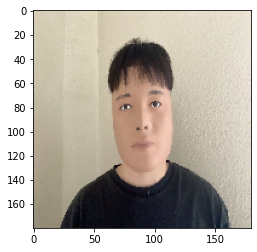

/home/kok/anaconda3/envs/yrkim/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
1it [00:00,  4.74it/s]

probs: [0.4070693850517273]
label : [1] , pred : [0.]


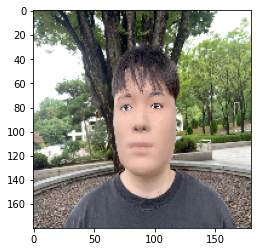

2it [00:00,  5.84it/s]

probs: [0.7948177456855774]
label : [1] , pred : [1.]


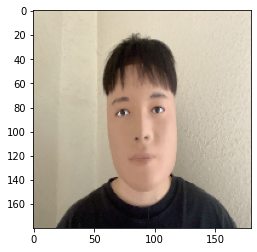

3it [00:00,  6.35it/s]

probs: [0.24557211995124817]
label : [1] , pred : [0.]


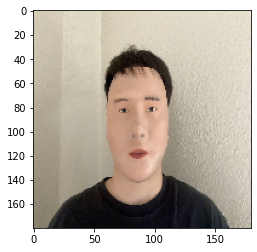

4it [00:00,  6.63it/s]

probs: [0.9249467849731445]
label : [1] , pred : [1.]


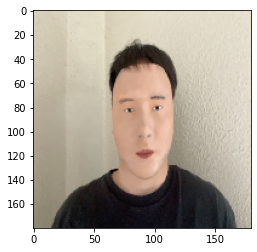

5it [00:00,  6.72it/s]

probs: [0.9479595422744751]
label : [1] , pred : [1.]


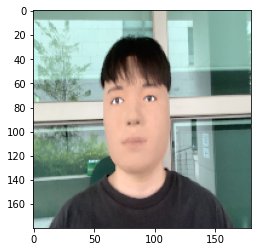

6it [00:00,  6.82it/s]

probs: [0.9420724511146545]
label : [1] , pred : [1.]


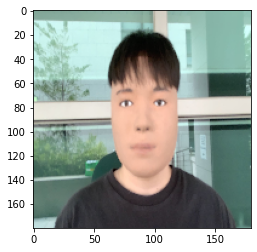

7it [00:01,  6.91it/s]

probs: [0.9134314060211182]
label : [1] , pred : [1.]


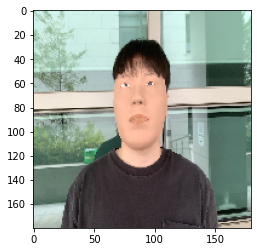

8it [00:01,  6.96it/s]

probs: [0.9773982167243958]
label : [1] , pred : [1.]


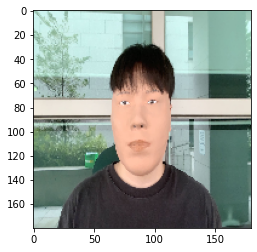

9it [00:01,  7.00it/s]

probs: [0.9563645124435425]
label : [1] , pred : [1.]


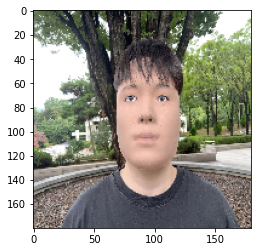

10it [00:01,  7.11it/s]

probs: [0.8191238641738892]
label : [1] , pred : [1.]


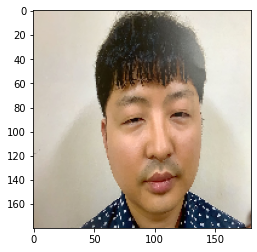

11it [00:01,  7.13it/s]

probs: [0.9837337732315063]
label : [1] , pred : [1.]


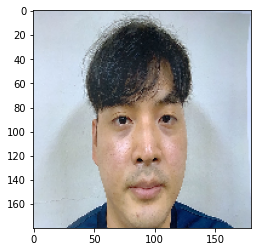

12it [00:01,  7.11it/s]

probs: [0.9972031116485596]
label : [1] , pred : [1.]


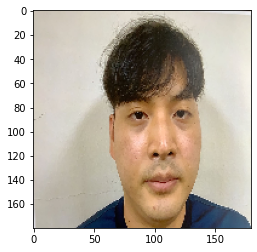

13it [00:01,  7.06it/s]

probs: [0.9954279661178589]
label : [1] , pred : [1.]


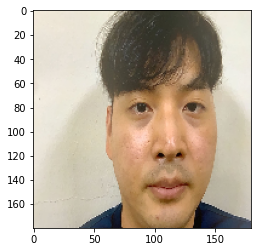

14it [00:02,  7.08it/s]

probs: [0.9765588045120239]
label : [1] , pred : [1.]


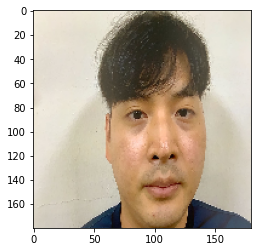

15it [00:02,  7.09it/s]

probs: [0.9739601612091064]
label : [1] , pred : [1.]


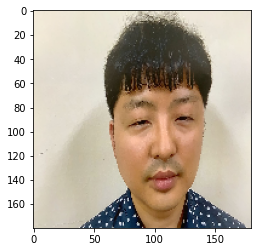

16it [00:02,  7.00it/s]

probs: [0.9812055826187134]
label : [1] , pred : [1.]


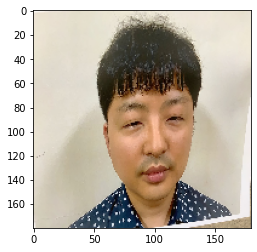

17it [00:02,  7.07it/s]

probs: [0.9559000730514526]
label : [1] , pred : [1.]


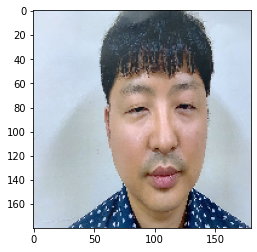

18it [00:02,  7.04it/s]

probs: [0.9976813793182373]
label : [1] , pred : [1.]


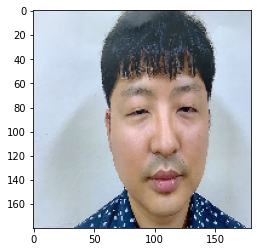

19it [00:02,  7.04it/s]

probs: [0.9976181387901306]
label : [1] , pred : [1.]


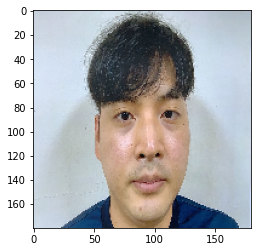

20it [00:02,  7.00it/s]

probs: [0.9972919821739197]
label : [1] , pred : [1.]


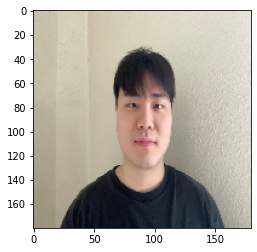

21it [00:03,  6.97it/s]

probs: [0.2898099720478058]
label : [0] , pred : [0.]


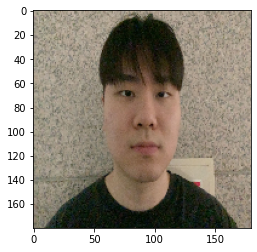

22it [00:03,  7.00it/s]

probs: [0.20740322768688202]
label : [0] , pred : [0.]


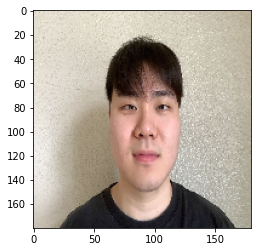

23it [00:03,  7.05it/s]

probs: [0.31467539072036743]
label : [0] , pred : [0.]


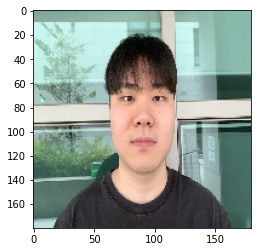

24it [00:03,  7.06it/s]

probs: [0.9124612212181091]
label : [0] , pred : [1.]


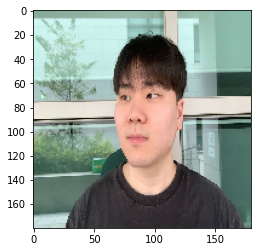

25it [00:03,  7.09it/s]

probs: [0.9116019010543823]
label : [0] , pred : [1.]


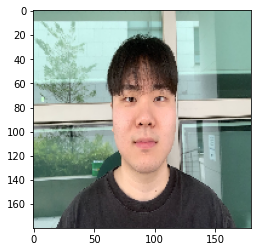

26it [00:03,  7.10it/s]

probs: [0.9296332597732544]
label : [0] , pred : [1.]


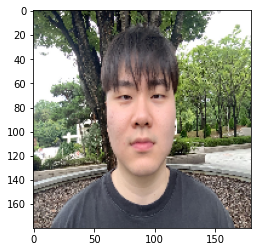

27it [00:03,  7.21it/s]

probs: [0.20156952738761902]
label : [0] , pred : [0.]


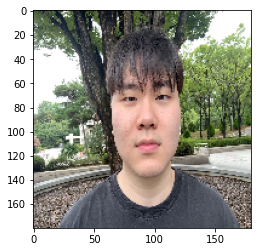

28it [00:04,  7.24it/s]

probs: [0.34687548875808716]
label : [0] , pred : [0.]


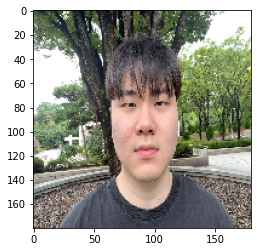

29it [00:04,  7.35it/s]

probs: [0.4107305407524109]
label : [0] , pred : [0.]


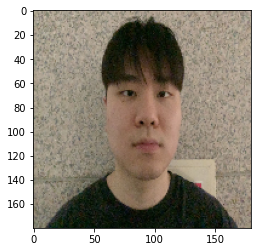

30it [00:04,  7.34it/s]

probs: [0.3154054880142212]
label : [0] , pred : [0.]


30it [00:04,  6.84it/s]


In [527]:
train_performs, test_performs = {'ACC':[],'F1':[]},{'ACC':[],'F1':[]}
best_test_f1 = 0
start_epoch = 0
epochs = 100
sigmoid = nn.Sigmoid()
loss_fn = nn.BCEWithLogitsLoss()

start_time = datetime.now()    
test_loss = []
test_probs, test_labels = [],[]
    
test_bar = tqdm(enumerate(test_loader))
for step, batch in test_bar :  
    rgb,cloud,label = batch[0].float().to(device),batch[1].float().to(device),batch[3].to(device)
#         cloud = cloud.permute(0,3,1,2)
#         features = torch.concat([rgb,cloud],dim=1)

    # RGB 
#     features = rgb[0].cpu().detach().int()
#     plt.imshow(features)
#     plt.show()
#     features = torch.tensor(features,dtype=torch.float32).unsqueeze(0).permute(0,3,1,2).to(device)
#     features = test_dataset.transforms(np.array(features[0].permute(1,2,0).cpu(),dtype=np.uint8))
#     features = features.unsqueeze(0).to(device)
    
#     logits,_ = model(features)
#     logits = logits[:,0]
#     loss = loss_fn(logits,label.float())

#     probs = sigmoid(logits)
    
#     print(f"probs: {probs.cpu().detach().tolist()}")
#     print('label : {} , pred : {}'.format(label.cpu().detach().tolist(),np.round(probs.cpu().detach().numpy())))
    
#     test_probs += probs.cpu().detach().tolist()
#     test_labels += label.cpu().detach().tolist()
    
    # RGB + Point Cloud
    image = rgb[0].cpu().detach().int()
    plt.imshow(image)
    plt.show()
    
    features = rgb[0].cpu().detach().int()
    features = torch.tensor(features,dtype=torch.float32).unsqueeze(0).permute(0,3,1,2).to(device)
    features = test_dataset.transforms(np.array(features[0].permute(1,2,0).cpu(),dtype=np.uint8))
    features = features.unsqueeze(0).to(device)
    
    features = torch.concat([features,cloud],dim=1)
        
    logits,_ = model(features)
    logits = logits[:,0]
    loss = loss_fn(logits,label.float())

    probs = sigmoid(logits)
    
    print(f"probs: {probs.cpu().detach().tolist()}")
    print('label : {} , pred : {}'.format(label.cpu().detach().tolist(),np.round(probs.cpu().detach().numpy())))
    
    test_probs += probs.cpu().detach().tolist()
    test_labels += label.cpu().detach().tolist()


In [528]:
# t = np.array(rgb[0].cpu(),dtype=np.uint8)
# plt.imshow(t)

In [529]:
# t = noisy('s&p',np.array(rgb[0].cpu(),dtype=np.uint8))
# print(t.shape)
# plt.imshow(t)

In [530]:
test_labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [531]:
np.round(test_probs)

array([0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.])

In [532]:
f1_score(np.array(test_labels), np.round(test_probs), average='macro')

0.8074454428754813

In [533]:
test_cf = confusion_matrix(np.array(test_labels), np.round(test_probs))
test_cf = pd.DataFrame(test_cf)
test_cf.columns = ['Predicted:0','Predicted:1']
test_cf.index = ['Label:0','Label:1']    
test_cf

,Predicted:0,Predicted:1
Label:0,7,3
Label:1,2,18


In [501]:
test_dataset.transforms

Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [502]:
t = test_dataset.transforms(np.array(features[0].permute(1,2,0).cpu(),dtype=np.uint8))
t = t.unsqueeze(0)

RuntimeError: The size of tensor a (6) must match the size of tensor b (3) at non-singleton dimension 0

In [503]:
features = noisy('s&p',rgb[0].cpu().permute(1,2,0))

TypeError: unsupported operand type(s) for *: 'float' and 'builtin_function_or_method'

In [504]:
from PIL import Image
im = rgb[0].cpu().permute(1,2,0)
# t = Image.fromarray(im.numpy())
# t.size/
# im.numpy().shape

In [226]:
t.shape

torch.Size([1, 3, 150, 90])

In [227]:
features.shape

torch.Size([1, 3, 150, 90])

In [228]:
features.shape

torch.Size([1, 3, 150, 90])

In [229]:
features

tensor([[[[-1.0904,  1.6838,  1.8550,  ...,  0.2453, -0.3541,  0.7762],
          [-1.7754,  1.8893,  0.9988,  ..., -1.5014, -1.6555,  1.4954],
          [ 1.3070,  1.1529,  0.7591,  ..., -1.8439, -1.1760, -1.5528],
          ...,
          [ 1.2043,  0.0227,  1.3584,  ..., -1.7583,  1.3242, -1.9295],
          [-1.4500,  1.4098, -1.5528,  ...,  0.2282,  0.7077,  0.4679],
          [-0.2684, -1.3130, -0.7993,  ..., -0.7993, -1.0048, -1.4158]],

         [[-1.4580,  0.8354,  2.2185,  ..., -0.7402,  2.1134,  1.2906],
          [ 2.1835, -0.3200,  0.3277,  ..., -1.2304,  1.7283,  0.4678],
          [-0.8627, -1.6856,  0.2052,  ...,  0.6429,  2.1835, -1.9832],
          ...,
          [ 1.2381,  1.8859,  1.2556,  ...,  1.7808, -2.0357, -1.7731],
          [ 0.9755, -0.4601,  0.1001,  ..., -0.8277,  1.6583, -0.5126],
          [-0.4251,  0.6954,  1.8683,  ...,  1.7633,  1.9209,  1.6933]],

         [[ 0.9494,  2.0823,  0.1128,  ..., -0.6367, -1.1421,  0.4439],
          [ 2.0300, -0.6018, -